Our problematic is that density is really respected in our network as long as it evolves.  
We must, therefore, find rules such that it can work properly, having nice and realistic 2D representation.

In [1]:
from gpn6 import GrowingPlanarNetwork, gpn_action
from helper import *
import networkx as nx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from heapq import heappush, heappop

In [31]:
class RGPN(GrowingPlanarNetwork):
    def init_tissue(self, size=3):
        super().init_tissue(size=size)
        total_size = size**2 - 1
        # set north
        for i in range(size):
            self.G.nodes[i]["side"] = self.G.nodes[i].get("side", set()) | {"N"}
        
        # set south
        for i in range(size):
            self.G.nodes[total_size - i]["side"] = self.G.nodes[total_size - i].get("side", set()) | {"S"}
        
        # set west
        for i in range(size):
            self.G.nodes[i * size]["side"] = self.G.nodes[i * size].get("side", set()) | {"W"}
        
        # set east
        for i in range(size):
            self.G.nodes[total_size - i * size]["side"] = \
                self.G.nodes[total_size - i * size].get("side", set()) | {"E"}
            
    def diffuse_border(self, node):
        # if the border is a corner, we can just return
        # ideally, we shall never have a length of 3 ...
        
        if self.is_border_node(node):
            if len(self.G.nodes[node].get("side", set())) >= 2:
                return
            ngb1, ngb2 = self.get_border_neighbours(node)
            side1 = self.G.nodes[ngb1].get("side", set())
            side2 = self.G.nodes[ngb2].get("side", set())
            side = self.G.nodes[node].get("side", set())
            assert len(side1 & side2) == 1, f"side is not of the right size, " \
                f"should be one : {side1}, {side2}, {ngb1}, {ngb2}" \
                f" with node {node}, {side}"
            self.G.nodes[node]["side"] = side1 & side2
            
        else:
            if "side" in self.G.nodes[node]:
                del self.G.nodes[node]["side"]
    
    def update_corner(self, node):
        if self.is_border_node(node):
            ngb1, ngb2 = self.get_border_neighbours(node)
            side1 = self.G.nodes[ngb1].get("side", set())
            side2 = self.G.nodes[ngb2].get("side", set())
            side_ref = self.G.nodes[node].get("side", set())
            
            if len(side1 & side2) == 0:
                self.G.nodes[ngb1]["side"] = side1 | side2
            
    # TODO override duplicate to set the border (NSEW)
    def duplicate(self, node):
        new_node = super().duplicate(node)
        self.diffuse_border(new_node)
            
    
    # TODO override remove to check for corners
    def destroy(self, node):
        self.update_corner(node)
                
        super().destroy(node)
    
    def edge_swapper(self):
        pass
    
    def update_all_dist(self):
        self.update_dist(direction="N")
        self.update_dist(direction="S")
        self.update_dist(direction="E")
        self.update_dist(direction="W")
        
    def mean_NS(self):
        return np.mean([self.G.nodes[n]["dist_N"] + self.G.nodes[n]["dist_S"] for n in self.G.nodes])
    
    def mean_EW(self):
        return np.mean([self.G.nodes[n]["dist_E"] + self.G.nodes[n]["dist_W"] for n in self.G.nodes])
    
    def update_dist(self, direction="N"):
        """
        Update for each node its distance to each sides
        Direction is one of NSEW
        """
        key = "dist_" + direction
        queue = []
        nodes = set(self.G.nodes)
        # NORTH
        for i in self.G.nodes:
            n = self.G.nodes[i]
            if direction in n.get("side", set()):
                value = 0
            else:
                value = np.inf
                
            n[key] = value
            heappush(queue, (value, i))
            
        while queue and nodes:
            _, inode = heappop(queue)
            if inode not in nodes:
                continue
                
            nodes.remove(inode)
            node = self.G.nodes[inode]
            value = node[key] + 1
            for ngb in node["ngb"]:
                if value < self.G.nodes[ngb][key]:
                    self.G.nodes[ngb][key] = value
                    heappush(queue, (value, ngb))

    
    def show_dist(self, k=5, iterations=1000, figsize=(10, 10), pos=None):
        # green for NS, red for EW
        plt.figure(figsize=figsize)
        if not pos:
            pos = nx.spring_layout(self.G, k=k, iterations=iterations)
        green = lambda x: format(max(0, 255 - (x["dist_N"] + x["dist_S"]) * 20), '02x')
        red = lambda x: format(max(0, 255 - (x["dist_E"] + x["dist_W"]) * 20), '02x')
        corner = lambda x: len(x.get("side", set())) >= 2
        def col_border(node):
            side = tuple(node.get("side", set()))
            return {
                ("N",): "#888822",  # yellow
                ("S",): "#228888",  # cyan
                ("E",): "#882288",  # purple
                ("W",): "#666666",  # grey
            }.get(side, "")
        colors = ["#000000" if corner(self.G.nodes[n]) else 
                  col_border(self.G.nodes[n])
                  or "#" + red(self.G.nodes[n]) + green(self.G.nodes[n]) + "ff" 
                  for n in self.G.nodes]
        nx.draw_networkx(self.G, pos, node_color=colors)
        
    def _reduce_on_axis(self, n, axis):
        """
        Warning, non node-cycle reducing, taking one step further
        Rationale is that empirically, we did not find much into cycle opportunity
        But we will have to do it later
        """
        assert axis in ["NS", "EW"], "Wrong axis argument"
        
        if self._quick_reduce(n, axis):
            print("Quick reducing", n, "on", axis)
            return True
        
        distA, distB = ("dist_N", "dist_S") if axis == "NS" else ("dist_E", "dist_W")
        node = self.G.nodes[n]
        N, S = node[distA], node[distB]
        ingbs = set(self.get_intermediate_neighbours(n)) - {-1}
        
        candidate_list = list()
        
        for ingb in ingbs:
            dngbs = self.ngb(ingb, net="dual")
            
            for edge_dngb in dngbs:
                node_dngb = self.get_other_node(edge_dngb, ingb)
                if node_dngb in (set(ingbs) | {-1}):
                    continue
                    
                # if #ngb == 2
                p_edge = self.dual(edge_dngb)
                if len(self.ngb(p_edge[0])) == 2 or len(self.ngb(p_edge[1])) == 2:
                    continue
                    
                pngbs = self.get_intermediate_neighbours(node_dngb, net="dual")
                
                # the best thing would be to make a list of possible
                # candidates then pick the very best, the same way as 
                # _augment
                for pngb in pngbs:
                    # no edge
                    if (n, pngb) in self.G.edges:
                        continue

                    pnode = self.G.nodes[pngb]
                    pN, pS = pnode[distA], pnode[distB]

                    # nothing to win (here for NS but works also for EW)
                    if pN >= N - 1 and pS >= S - 1:
                        continue
                        
                    candidate_list.append((self.dual(edge_dngb), pngb))
                    
        if len(candidate_list) == 0:
            print(f"No candidates for node {n} in _reduce")
            return False

        candidate_list.sort(key=lambda x: len(self.ngb(x[1])))

        p_edge, pngb = candidate_list[0]
        print(f"Reducing node {n}")
        self.replace_edge(p_edge, (n, pngb))
        return True
                
    def _get_border_candidates(self, node):
        assert self.is_border_node(node)
        return [n for ngb in gpn.get_border_neighbours(node)
                for n in gpn.get_border_neighbours(ngb)
                if n != node]
    
    def _get_quick_candidates(self, node, dual_node):
        assert dual_node != -1, "Operation not allowed for dual -1"
        return [ngb for ngb in 
                self.get_intermediate_neighbours(dual_node, net="dual")
                if ngb != node]
    
    def _get_common_border_ngb(self, n_a, n_b):
        s_a = set(gpn.get_border_neighbours(n_a))
        s_b = set(gpn.get_border_neighbours(n_b))
        return list(s_a & s_b)[0]
                
    def _quick_reduce(self, n, axis):
        """
        The idea is the same as "_reduce_on_axis" but here
        we just create a direct edge without removing anything
        directly (maybe something will be removed through
        stabilize_ngb later)
        """
        assert axis in ["NS", "EW"], "Wrong axis argument"
        
        A, B = axis
        node = self.G.nodes[n]
        N, S = self._dist(n, A), self._dist(n, B)
        dist = self._dist(n, axis)
        # get dual nodes
        ingbs = self.get_intermediate_neighbours(n)
        
        # gather all candidates without any filter
        candidates = []
        for ingb in ingbs:
            if ingb == -1:
                ls_c = self._get_border_candidates(n)
            else:
                ls_c = self._get_quick_candidates(n, ingb)
            candidates += [(c, ingb) for c in ls_c]
                
        # filter candidates
        filtered_candidates = [(c, d) for c, d in candidates
                               if self._dist(c, A) < N - 1
                               or self._dist(c, B) < S - 1]
        
        # pick best
        random.shuffle(filtered_candidates)
        
        # TODO number of ngb does not correct for already ngb with the next removed edge
        # neither border sides
        filtered_candidates.sort(key=lambda x: len(self.ngb(x[0])))

        # if empty
        if len(filtered_candidates) == 0:
            return False
            
        # select the best one (the first)
        candidate, dual = filtered_candidates[0]
        self.build_new_edge(n, candidate, dual)
        return True
        
    def build_new_edge(self, n, candidate, dual):
        if dual == -1:
            ref_node = self._get_common_border_ngb(n, candidate)
            if self.is_corner(ref_node):
                self.update_corner(ref_node)
            self._make_border_edge(ref_node, (n, candidate))
            self.diffuse_border(ref_node)
        else:
            self._make_edge(dual, (n, candidate))
            
        return True
                
    @gpn_action
    def replace_edge(self, edge1, edge2):
        dual_node = self._remove_edge(edge1)
        # print("Dual node", dual_node)
        self._make_edge(dual_node, edge2)
        
    def shorten_dist(self):
        """
        For now, one max action per round, otherwise tricky mechanisms could occur
        """
        self.update_all_dist()
        mean_NS = self.mean_NS()
        mean_EW = self.mean_EW()
        # find nodes with most pressure
        # for threshold, let's say *1.5 compared to mean
        nodes = list(self.G.nodes)
        random.shuffle(nodes)
        # TODO we must sort from the most "out" to the less
        # list candidates
        candidates = list()
        for n in nodes:
            node = self.G.nodes[n]
            val_NS = (node["dist_N"] + node["dist_S"]) / mean_NS
            val_EW = (node["dist_E"] + node["dist_W"]) / mean_EW
            if val_NS >= 1.1:
                candidates.append((n, "NS", val_NS))
                
            if val_EW >= 1.1:
                candidates.append((n, "EW", val_EW))
            
        # pick best candidate
        candidates.sort(key=lambda x: x[2], reverse=True)
        for n, axis, _ in candidates:
            if self._reduce_on_axis(n, axis=axis):
                self.check_all()
                self.stabilize_around(n)
                return True
            
            else:
                print(f"Impossible shorten for node {n} on axis {axis}")
        
        # success is implicit
        return False
                
    def maxen_dist(self):
        self.update_all_dist()
        mean_NS = self.mean_NS()
        mean_EW = self.mean_EW()
        # find nodes with most pressure
        # for threshold, let's say *1.5 compared to mean
        nodes = list(self.G.nodes)
        random.shuffle(nodes)
        candidates = list()
        for n in nodes:
            node = self.G.nodes[n]
            val_NS = (node["dist_N"] + node["dist_S"]) / mean_NS
            val_EW = (node["dist_E"] + node["dist_W"]) / mean_EW
            if val_NS <= 0.9:
                candidates.append((n, "NS", val_NS))
                
            if val_EW <= 0.9:
                candidates.append((n, "EW", val_EW))
            
        # pick best candidate
        candidates.sort(key=lambda x: x[2], reverse=False)
        for n, axis, _ in candidates:
            if self._augment(n, axis=axis):
                self.stabilize_around(n)
                return True
        
        # success is implicit
        return False
    
    def get_all_dists(self):
        l_NS, l_EW, l_both = list(), list(), list()
        nodes = list(self.G.nodes)
        candidates = list()
        for n in nodes:
            node = self.G.nodes[n]
            val_NS = (node["dist_N"] + node["dist_S"])
            val_EW = (node["dist_E"] + node["dist_W"])
            l_NS.append(val_NS)
            l_EW.append(val_EW)
            l_both.append(val_NS + val_EW)
            
        return l_NS, l_EW, l_both
    
    def print_dist_metrics(self):
        lA, lB, lC = self.get_all_dists()
        xA, xB, xC = np.std(lA) / np.mean(lA), np.std(lB) / np.mean(lB), np.std(lC) / np.mean(lC)
        print(f"Score are for NS : {xA}, EW : {xB}, both : {xC}")

    @gpn_action
    def setup_edge(self, edge, dual_node, candidate):
        # setup the edge and delete the one chosen
        node1, node2 = edge
        if (node1, candidate) not in self.G.edges:
            other_dual = self._make_edge(dual_node, (node1, candidate))
            # update dual_node
            ingb = set(self.get_intermediate_neighbours(dual_node, net="dual"))
            if not ingb.issuperset({node2, candidate}):
                dual_node, other_dual = other_dual, dual_node
            
        if (node2, candidate) not in self.G.edges:
            self._make_edge(dual_node, (node2, candidate))
        
        self._remove_edge(edge)
        self.diffuse_border(candidate)
    
    # TODO, find a better way
    def _dist(self, n, axis):
        node = self.G.nodes[n]
        return sum([node["dist_" + str(x)] for x in axis])
                
    def _augment(self, n, axis="NS"):
        A, B = axis
        node = self.G.nodes[n]
        N, S = self._dist(n, A), self._dist(n, B)
        dist = self._dist(n, axis)
        target_node = None
        # first step, find ngb that has the same dist
        for ngb in self.ngb(n):
            if self._dist(ngb, axis) <= dist:
                target_node = ngb
                break
                
        # stop here if #ngb == 2
        if len(self.ngb(n)) == 2 or len(self.ngb(target_node)) == 2:
            return False
                
        if target_node == None:
            raise RuntimeError(f"Should not have no ngb with same dist, dist is {dist}")
            
        dual_nodes = set(self.dual((n, target_node))[:2]) - {-1}
        
        # build list of candidate link node
        candidate_list = []
        for dual_node in dual_nodes:
            pngbs = set(self.get_intermediate_neighbours(dual_node, net="dual")) - {n, target_node}
            candidate_list += [(dual_node, pngb) for pngb in pngbs 
                               if self._dist(pngb, A) >= N and self._dist(pngb, B) >= S]
            
        random.shuffle(candidate_list)
        # TODO number of ngb does not correct for already ngb with the next removed edge
        candidate_list.sort(key=lambda x: len(self.ngb(x[1])))

        # if empty
        if len(candidate_list) == 0:
            return False
            
        # select the best one (the first)
        dual, candidate = candidate_list[0]
        
        self.setup_edge((n, target_node), dual, candidate)
        return True

In [32]:
seed = 1
random.seed(seed)
np.random.seed(seed)
gpn = RGPN()
gpn.init_tissue(6)
gpn.update_all_dist()

def p_dupl():
    return np.random.random() > 0.46

In [42]:
np.min(np.array(list(pos.values()))), np.max(np.array(list(pos.values())))

(-0.7854771389845343, 0.9999999999999999)

In [45]:
def node_pos(node):
    x = node["dist_N"] / (node["dist_N"] + node["dist_S"])
    y = node["dist_E"] / (node["dist_E"] + node["dist_W"])
    x, y = (x - 0.5) * 1.5, (y - 0.5) * 1.5
    return np.array([x, y])

def embedded_viz(gpn):
    gpn.update_all_dist()
    # pos is a dict of np array with coordinates
    pos = {n: node_pos(gpn.G.nodes[n]) for n in gpn.G.nodes}
    return pos

In [39]:
seed = 1
random.seed(seed)
np.random.seed(seed)
gpn = RGPN()
gpn.debug = True
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = True

def quick_export(gpn, pos, name):
    global ignore_export
    if ignore_export:
        return
    gpn.update_all_dist()
    gpn.show_dist(pos=pos, figsize=(8, 8))
    plt.savefig(name)
    plt.close()

pos = nx.spring_layout(gpn.G, k=0.1, iterations=50)
root = "output/evonet8/"
ratio = 0
for i in range(300):
    # print(gpn.G.number_of_nodes(), ratio)
    # gpn.check_all()
    print()
    print("-" * 50)
    print()
    print(f"Run {i}")
    if p_dupl():
        ratio += 1
        gpn.duplicate_random()
    else:
        ratio -= 1
        gpn.destroy_random()
        
    pos = nx.spring_layout(gpn.G, pos=pos, k=0.1, iterations=10)
    quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    gpn.print_dist_metrics()

    if gpn.shorten_dist():
        pos = nx.spring_layout(gpn.G, pos=pos, k=0.1, iterations=10)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png")
        print("Shorten")
        gpn.update_all_dist()
        gpn.print_dist_metrics()

    if gpn.maxen_dist():
        pos = nx.spring_layout(gpn.G, pos=pos, k=0.1, iterations=10)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_c.png")
        print("Maxen")
        gpn.update_all_dist()
        gpn.print_dist_metrics()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())

Calling _init_square  with  () {'size': 8}

--------------------------------------------------

Run 0
Calling _destroy_node  with  (17,) {}
Action
Score are for NS : 0.0, EW : 0.0, both : 0.0

Iteration 0 ratio -1 density 0.08035714285714286

--------------------------------------------------

Run 1
Calling _duplicate_node  with  (28,) {}
Action
Score are for NS : 0.04868401632666737, EW : 0.04390106451744655, both : 0.03508771929824561
Quick reducing 31 on EW
Shorten
Score are for NS : 0.04868401632666737, EW : 0.04108977556426791, both : 0.03455560096311129

--------------------------------------------------

Run 2
Calling _destroy_node  with  (45,) {}
Action
Score are for NS : 0.04137190606019447, EW : 0.04137190606019447, both : 0.03287905695010977
Quick reducing 29 on EW
Shorten
Score are for NS : 0.04137190606019447, EW : 0.01781449745251541, both : 0.02560136485206084

--------------------------------------------------

Run 3
Calling _destroy_node  with  (42,) {}
Action
Score ar

Maxen
Score are for NS : 0.10698972158776239, EW : 0.1099802443630115, both : 0.08478490500798731

--------------------------------------------------

Run 20
Calling _destroy_node  with  (38,) {}
Action
Score are for NS : 0.10593145553066642, EW : 0.10724614730194791, both : 0.0776329284276064
Quick reducing 37 on NS
Shorten
Score are for NS : 0.09594153337585577, EW : 0.10724614730194791, both : 0.06900072317407256
Calling setup_edge  with  ((10, 2), 49, 9) {}
Maxen
Score are for NS : 0.09214323267878476, EW : 0.10724614730194791, both : 0.06548706312851935

--------------------------------------------------

Run 21
Calling _duplicate_node  with  (0,) {}
Action
Score are for NS : 0.09392407122542887, EW : 0.1028617562334609, both : 0.06410751716645871
Reducing node 53
Calling replace_edge  with  ((52, 60), (53, 59)) {}
Shorten
Score are for NS : 0.09392407122542887, EW : 0.08951874156623552, both : 0.06004361401096384
Calling setup_edge  with  ((57, 49), 42, 56) {}
Maxen
Score are for

Maxen
Score are for NS : 0.0755577933351017, EW : 0.12598755386610405, both : 0.06641998065263477

--------------------------------------------------

Run 37
Calling _duplicate_node  with  (50,) {}
Action
Score are for NS : 0.07998024153590083, EW : 0.13842319630212116, both : 0.07696673871735356
Quick reducing 49 on EW
Shorten
Score are for NS : 0.08496702117393432, EW : 0.1328961779330681, both : 0.07855844048495726
Calling setup_edge  with  ((69, 64), 113, 35) {}
Maxen
Score are for NS : 0.08496702117393432, EW : 0.1328961779330681, both : 0.07855844048495726

--------------------------------------------------

Run 38
Calling _duplicate_node  with  (69,) {}
Action
Score are for NS : 0.09549847530793593, EW : 0.12970597761410044, both : 0.08011942324320821
Quick reducing 50 on EW
Shorten
Score are for NS : 0.09032106474595009, EW : 0.1238494762890754, both : 0.0743781959607999
Calling setup_edge  with  ((5, 4), 111, 75) {}
Maxen
Score are for NS : 0.08237720140507343, EW : 0.11493180

Maxen
Score are for NS : 0.12611631711950275, EW : 0.07559289460184546, both : 0.08714335508060883

--------------------------------------------------

Run 55
Calling _duplicate_node  with  (66,) {}
Action
Score are for NS : 0.13798465415332828, EW : 0.0922958206990897, both : 0.10306371609364649
Reducing node 66
Calling replace_edge  with  ((46, 86), (66, 62)) {}
Shorten
Score are for NS : 0.14157593314415434, EW : 0.08733379056596591, both : 0.10194373714966848
Calling setup_edge  with  ((36, 44), 155, 69) {}
Maxen
Score are for NS : 0.14361137779241254, EW : 0.08733379056596591, both : 0.10307834971171681

--------------------------------------------------

Run 56
Calling _duplicate_node  with  (83,) {}
Action
Score are for NS : 0.13612321014168977, EW : 0.1291286156518581, both : 0.11490901458394402
Quick reducing 46 on NS
Shorten
Score are for NS : 0.12289185910675893, EW : 0.12464183962522711, both : 0.10503876739008967
Calling setup_edge  with  ((36, 74), 160, 37) {}
Maxen
Score

Maxen
Score are for NS : 0.24067773425375688, EW : 0.211642532934086, both : 0.20740181140153768

--------------------------------------------------

Run 72
Calling _destroy_node  with  (84,) {}
Removing crossing border edge 81 92 (164, 198, 0)
Action
Score are for NS : 0.23138554244609863, EW : 0.20865916437968404, both : 0.20022389133275323
Reducing node 53
Calling replace_edge  with  ((46, 60), (53, 61)) {}
Shorten
Score are for NS : 0.23717072451824667, EW : 0.20397288611873132, both : 0.20022389133275323
Calling setup_edge  with  ((58, 41), 227, 71) {}
Maxen
Score are for NS : 0.21143870007205193, EW : 0.21996372978035833, both : 0.19239325417526032

--------------------------------------------------

Run 73
Calling _duplicate_node  with  (67,) {}
Action
Score are for NS : 0.2250388393453623, EW : 0.21850089365954192, both : 0.1976908332387047
Quick reducing 95 on EW
Removing crossing border edge 61 95 (205, 233, 0)
Shorten
Score are for NS : 0.22146555605980564, EW : 0.2229171733

Action
Score are for NS : 0.1177761405037802, EW : 0.16109343227385395, both : 0.12739250675227026
Quick reducing 46 on NS
Shorten
Score are for NS : 0.1177761405037802, EW : 0.16475089420958278, both : 0.13026178177244216
Calling setup_edge  with  ((57, 58), 133, 70) {}
Maxen
Score are for NS : 0.1433262381603182, EW : 0.15570566241205774, both : 0.1353271075501208

--------------------------------------------------

Run 91
Calling _duplicate_node  with  (27,) {}
Quasi lonely node 27 with #ngbs = 2
Action
Score are for NS : 0.14805351248336932, EW : 0.1647187251827419, both : 0.14285714285714285
Quick reducing 27 on EW
Shorten
Score are for NS : 0.14805351248336932, EW : 0.15930231976004863, both : 0.1402136819482013
Calling setup_edge  with  ((81, 44), 267, 90) {}
Maxen
Score are for NS : 0.14805351248336932, EW : 0.15802831743719556, both : 0.13947017024999506

--------------------------------------------------

Run 92
Calling _destroy_node  with  (103,) {}
Action
Score are for NS :

Maxen
Score are for NS : 0.12263779848516969, EW : 0.12332207155790618, both : 0.10243768855711002

--------------------------------------------------

Run 108
Calling _duplicate_node  with  (108,) {}
Action
Score are for NS : 0.12012339334879628, EW : 0.1252963082375492, both : 0.10276752359373648
Quick reducing 46 on EW
Shorten
Score are for NS : 0.12012339334879628, EW : 0.1252963082375492, both : 0.10276752359373648
Calling setup_edge  with  ((82, 21), 154, 36) {}
Maxen
Score are for NS : 0.12096637518040329, EW : 0.1256142072921326, both : 0.10374386050327572

--------------------------------------------------

Run 109
Calling _duplicate_node  with  (18,) {}
Quasi lonely node 18 with #ngbs = 2
Action
Score are for NS : 0.12011459594411537, EW : 0.12724778976469492, both : 0.10414124238203884
Quick reducing 46 on EW
Shorten
Score are for NS : 0.12011459594411537, EW : 0.12724778976469492, both : 0.10414124238203884
Calling setup_edge  with  ((10, 78), 284, 105) {}
Maxen
Score are f

Score are for NS : 0.16698593517344315, EW : 0.1142992313015315, both : 0.11931967241268636
Calling setup_edge  with  ((125, 27), 270, 118) {}
Maxen
Score are for NS : 0.16000040764487, EW : 0.112039796382194, both : 0.11917573344934186

--------------------------------------------------

Run 127
Calling _duplicate_node  with  (46,) {}
Action
Score are for NS : 0.1707216891919232, EW : 0.1203858530857692, both : 0.1295253351863536
Quick reducing 46 on NS
Shorten
Score are for NS : 0.16490836419101082, EW : 0.1203858530857692, both : 0.12686600261426817
Calling setup_edge  with  ((58, 18), 247, 119) {}
Maxen
Score are for NS : 0.1572843954126413, EW : 0.12132591588644841, both : 0.12451182917677384

--------------------------------------------------

Run 128
Calling _duplicate_node  with  (53,) {}
Action
Score are for NS : 0.17928356378976948, EW : 0.13836604975267142, both : 0.1459805394206704
Quick reducing 129 on NS
Shorten
Score are for NS : 0.15796105346386802, EW : 0.1214023080841

Shorten
Score are for NS : 0.1688204712775149, EW : 0.17512188463238476, both : 0.15748202460505692
Calling setup_edge  with  ((110, 94), 361, 104) {}
Maxen
Score are for NS : 0.1688204712775149, EW : 0.17512188463238476, both : 0.15748202460505692

--------------------------------------------------

Run 144
Calling _destroy_node  with  (99,) {}
Action
Score are for NS : 0.16377340335614352, EW : 0.17553248852145534, both : 0.15643359440523683
Reducing node 53
Calling replace_edge  with  ((101, 61), (53, 62)) {}
Shorten
Score are for NS : 0.1607900036393273, EW : 0.17251940645185776, both : 0.15298152302358103
Calling setup_edge  with  ((110, 125), 331, 28) {}
Maxen
Score are for NS : 0.1607900036393273, EW : 0.16629227282107847, both : 0.15026374057692174

--------------------------------------------------

Run 145
Calling _duplicate_node  with  (5,) {}
Quasi lonely node 140 with #ngbs = 2
Action
Score are for NS : 0.16331409824337334, EW : 0.17611718649401412, both : 0.15723091750252

Shorten
Score are for NS : 0.16260707553966627, EW : 0.15047359249179607, both : 0.13728885707144983
Calling setup_edge  with  ((67, 36), 376, 137) {}
Maxen
Score are for NS : 0.15289211568462033, EW : 0.15047359249179607, both : 0.14257201545241674

--------------------------------------------------

Run 160
Calling _destroy_node  with  (111,) {}
Quasi lonely node 113 with #ngbs = 2
Action
Score are for NS : 0.16998439706882174, EW : 0.14955630009492527, both : 0.14743978905794355
Quick reducing 132 on NS
Shorten
Score are for NS : 0.16613919801483312, EW : 0.14765039149764345, both : 0.14452886388107308
Calling setup_edge  with  ((125, 27), 357, 118) {}
Maxen
Score are for NS : 0.16039577397806604, EW : 0.14416381775916506, both : 0.14063958308445032

--------------------------------------------------

Run 161
Calling _duplicate_node  with  (69,) {}
Action
Score are for NS : 0.15962703957556262, EW : 0.14121240866553683, both : 0.13791732625357164
Quick reducing 43 on EW
Shorten
Scor

Quasi lonely node 86 with #ngbs = 2
Action
Score are for NS : 0.15615770827452474, EW : 0.16392252536466662, both : 0.14762134782138686
Reducing node 43
Calling replace_edge  with  ((117, 130), (43, 41)) {}
Shorten
Score are for NS : 0.15615770827452474, EW : 0.16392252536466662, both : 0.14762134782138686
Calling setup_edge  with  ((116, 28), 305, 133) {}
Maxen
Score are for NS : 0.15615770827452474, EW : 0.15674697655682152, both : 0.14284411289929966

--------------------------------------------------

Run 177
Calling _duplicate_node  with  (93,) {}
Action
Score are for NS : 0.15969015367136485, EW : 0.1561180586108713, both : 0.14220243206561722
Reducing node 43
Calling replace_edge  with  ((117, 130), (43, 41)) {}
Shorten
Score are for NS : 0.15969015367136485, EW : 0.1561180586108713, both : 0.14220243206561722
Calling setup_edge  with  ((94, 118), 433, 119) {}
Maxen
Score are for NS : 0.16222142113076254, EW : 0.1515670836021902, both : 0.14191410520182798

---------------------

Maxen
Score are for NS : 0.20247798277038367, EW : 0.16918784856030555, both : 0.1656035954503172

--------------------------------------------------

Run 193
Calling _duplicate_node  with  (142,) {}
Action
Score are for NS : 0.19965029958849093, EW : 0.16816593667058385, both : 0.16355564280629498
Quick reducing 43 on NS
Shorten
Score are for NS : 0.19965029958849093, EW : 0.16816593667058385, both : 0.16355564280629498
Calling setup_edge  with  ((104, 119), 463, 94) {}
Maxen
Score are for NS : 0.19587952259944602, EW : 0.16816593667058385, both : 0.16233500492373562

--------------------------------------------------

Run 194
Calling _destroy_node  with  (57,) {}
Action
Score are for NS : 0.19678093417114592, EW : 0.16825890523587617, both : 0.1648839624370322
Quick reducing 43 on NS
Shorten
Score are for NS : 0.19678093417114592, EW : 0.16825890523587617, both : 0.1648839624370322
Calling setup_edge  with  ((160, 154), 392, 19) {}
Maxen
Score are for NS : 0.1904402388044222, EW : 0.

Maxen
Score are for NS : 0.16819502640020004, EW : 0.20901928559527524, both : 0.17083768469402338

--------------------------------------------------

Run 212
Calling _duplicate_node  with  (147,) {}
Action
Score are for NS : 0.16707487662871662, EW : 0.21544306495170237, both : 0.1734696164073374
Quick reducing 43 on EW
Shorten
Score are for NS : 0.17142949070932734, EW : 0.21544306495170237, both : 0.17576015581784696
Calling setup_edge  with  ((118, 119), 496, 163) {}
Maxen
Score are for NS : 0.16825034165689923, EW : 0.21155090408900215, both : 0.17201228604295968

--------------------------------------------------

Run 213
Calling _destroy_node  with  (132,) {}
Action
Score are for NS : 0.16746836804864074, EW : 0.21193203027321283, both : 0.17155498942939235
Quick reducing 43 on EW
Shorten
Score are for NS : 0.16746836804864074, EW : 0.21193203027321283, both : 0.17155498942939235
Calling setup_edge  with  ((19, 100), 482, 104) {}
Maxen
Score are for NS : 0.20330984266523247, EW

Maxen
Score are for NS : 0.2689780676814085, EW : 0.2573719923274968, both : 0.22108444554160084

--------------------------------------------------

Run 230
Calling _destroy_node  with  (118,) {}
Action
Score are for NS : 0.25053046594977807, EW : 0.24763745771374518, both : 0.20219405666563997
Quick reducing 109 on EW
Shorten
Score are for NS : 0.25300529781294556, EW : 0.2344641082530268, both : 0.19466287458379283
Calling setup_edge  with  ((28, 173), 555, 176) {}
Maxen
Score are for NS : 0.27378299943807066, EW : 0.19026823569873835, both : 0.1996030827620884

--------------------------------------------------

Run 231
Calling _duplicate_node  with  (137,) {}
Action
Score are for NS : 0.2741449548067696, EW : 0.18909912099966916, both : 0.19882468935472714
Reducing node 53
Calling replace_edge  with  ((130, 43), (53, 61)) {}
Shorten
Score are for NS : 0.2741449548067696, EW : 0.18616176948094593, both : 0.19761992228064082
Calling setup_edge  with  ((28, 119), 560, 96) {}
Maxen
Sc

Shorten
Score are for NS : 0.20953978929526226, EW : 0.23767695091943494, both : 0.20746859213662158
Calling setup_edge  with  ((153, 181), 574, 96) {}
Maxen
Score are for NS : 0.29030989544096925, EW : 0.26023999788109275, both : 0.253181267503863

--------------------------------------------------

Run 250
Calling _destroy_node  with  (144,) {}
Action
Score are for NS : 0.29611802653108793, EW : 0.266320050815031, both : 0.25942203048774193
Quick reducing 191 on EW
Shorten
Score are for NS : 0.29611802653108793, EW : 0.26307414031048665, both : 0.257684164713845
Calling setup_edge  with  ((133, 28), 483, 190) {}
Maxen
Score are for NS : 0.2876755145056502, EW : 0.2652270732318598, both : 0.2540273692305743

--------------------------------------------------

Run 251
Calling _duplicate_node  with  (158,) {}
Action
Score are for NS : 0.2899757755627583, EW : 0.2669464175675799, both : 0.25681253519949904
Quick reducing 192 on NS
Shorten
Score are for NS : 0.28765185110933017, EW : 0.26

Maxen
Score are for NS : 0.24249256836452623, EW : 0.3545471512442998, both : 0.28414585055216623

--------------------------------------------------

Run 267
Calling _destroy_node  with  (53,) {}
Action
Score are for NS : 0.23521827622921243, EW : 0.3518976335887715, both : 0.27955671267021803
Quick reducing 175 on EW
Shorten
Score are for NS : 0.22814467422933743, EW : 0.3442168024669797, both : 0.2714270889112091
Calling setup_edge  with  ((205, 154), 502, 193) {}
Maxen
Score are for NS : 0.2288278258406949, EW : 0.34193631195530755, both : 0.2703318145184329

--------------------------------------------------

Run 268
Calling _destroy_node  with  (166,) {}
Action
Score are for NS : 0.2301819076558256, EW : 0.3425479560841296, both : 0.27165916716513905
Reducing node 175
Calling replace_edge  with  ((119, 196), (175, 207)) {}
Shorten
Score are for NS : 0.23176816388107, EW : 0.3448533681590637, both : 0.27416503335268655
Calling setup_edge  with  ((193, 154), 676, 72) {}
Maxen
Score

Shorten
Score are for NS : 0.2692019197154246, EW : 0.3689320988615191, both : 0.3102684465634516
Calling setup_edge  with  ((14, 133), 707, 148) {}
Maxen
Score are for NS : 0.2692019197154246, EW : 0.3808651778912831, both : 0.31470595421394215

--------------------------------------------------

Run 285
Calling _duplicate_node  with  (187,) {}
Quasi lonely node 187 with #ngbs = 2
Action
Score are for NS : 0.26920374183721835, EW : 0.37795713795245195, both : 0.3128954813747404
Reducing node 211
Calling replace_edge  with  ((145, 210), (211, 86)) {}
Shorten
Score are for NS : 0.26920374183721835, EW : 0.37795713795245195, both : 0.3128954813747404
Calling setup_edge  with  ((19, 75), 727, 215) {}
Maxen
Score are for NS : 0.26920374183721835, EW : 0.38018967888277655, both : 0.31554125951425627

--------------------------------------------------

Run 286
Calling _duplicate_node  with  (175,) {}
Action
Score are for NS : 0.2707907516722029, EW : 0.38111202865384614, both : 0.31707542528

In [48]:
seed = 2
random.seed(seed)
np.random.seed(seed)
gpn = RGPN()
gpn.debug = True
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = False

def quick_export(gpn, pos, name):
    global ignore_export
    if ignore_export:
        return
    gpn.update_all_dist()
    gpn.show_dist(pos=pos, figsize=(8, 8))
    plt.savefig(name)
    plt.close()

pos = nx.spring_layout(gpn.G, k=0.1, iterations=50)
root = "output/evonet8/"
ratio = 0
for i in range(300):
    # print(gpn.G.number_of_nodes(), ratio)
    # gpn.check_all()
    print()
    print("-" * 50)
    print()
    print(f"Run {i}")
    if i < 100:
        if p_dupl():
            ratio += 1
            gpn.duplicate_random()
        else:
            ratio -= 1
            gpn.destroy_random()
        
    pos = embedded_viz(gpn)
    quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    gpn.print_dist_metrics()

    if gpn.shorten_dist():
        pos = embedded_viz(gpn)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png")
        print("Shorten")
        gpn.update_all_dist()
        gpn.print_dist_metrics()

    if gpn.maxen_dist():
        pos = embedded_viz(gpn)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_c.png")
        print("Maxen")
        gpn.update_all_dist()
        gpn.print_dist_metrics()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())

Calling _init_square  with  () {'size': 8}

--------------------------------------------------

Run 0
Calling _destroy_node  with  (7,) {}
Action
Score are for NS : 0.0, EW : 0.04561979233461597, both : 0.022627416997969524
Calling setup_edge  with  ((5, 4), 4, 13) {}
Maxen
Score are for NS : 0.06133864568481871, EW : 0.038182480641090595, both : 0.03826642173766337

Iteration 0 ratio -1 density 0.08035714285714286

--------------------------------------------------

Run 1
Calling _destroy_node  with  (16,) {}
Action
Score are for NS : 0.07104794552601071, EW : 0.034775219661479034, both : 0.041728039728706694
Quick reducing 10 on EW
Shorten
Score are for NS : 0.07104794552601071, EW : 0.025124887958952576, both : 0.03843856035825846

--------------------------------------------------

Run 2
Calling _destroy_node  with  (39,) {}
Action
Score are for NS : 0.07618388046902588, EW : 0.025321166646154344, both : 0.04102726510015224
Quick reducing 11 on EW
Shorten
Score are for NS : 0.07618

Action
Score are for NS : 0.06665384985088607, EW : 0.08574700820781556, both : 0.06301954097412779
Quick reducing 6 on NS
Shorten
Score are for NS : 0.061057342594364905, EW : 0.08574700820781556, both : 0.05941694197203951

--------------------------------------------------

Run 19
Calling _destroy_node  with  (72,) {}
Action
Score are for NS : 0.07734818608815328, EW : 0.08180311857336536, both : 0.06204617525734186
Quick reducing 6 on EW
Shorten
Score are for NS : 0.07886068896771578, EW : 0.07660909987781132, both : 0.060603043502854954
Calling setup_edge  with  ((53, 61), 69, 62) {}
Maxen
Score are for NS : 0.060287377627780164, EW : 0.07660909987781132, both : 0.05569056158238845

--------------------------------------------------

Run 20
Calling _destroy_node  with  (66,) {}
Action
Score are for NS : 0.059429527314767853, EW : 0.06591026911238415, both : 0.04770561760673847
Quick reducing 69 on EW
Shorten
Score are for NS : 0.07349141800515326, EW : 0.060061647822533065, both :

Shorten
Score are for NS : 0.14272480642961255, EW : 0.15108231343279926, both : 0.10566567000003535
Calling setup_edge  with  ((67, 59), 116, 44) {}
Maxen
Score are for NS : 0.20513673924145967, EW : 0.15904529424864594, both : 0.15310500210234249

--------------------------------------------------

Run 37
Calling _duplicate_node  with  (55,) {}
Action
Score are for NS : 0.22455764597010802, EW : 0.1594971548449317, both : 0.16302412666058086
Quick reducing 77 on NS
Shorten
Score are for NS : 0.2200382121327593, EW : 0.1594971548449317, both : 0.1604931390072018
Calling setup_edge  with  ((10, 9), 108, 18) {}
Maxen
Score are for NS : 0.21605856070263119, EW : 0.1594971548449317, both : 0.15922167369336224

--------------------------------------------------

Run 38
Calling _destroy_node  with  (65,) {}
Action
Score are for NS : 0.20731478690753197, EW : 0.12487810821089253, both : 0.14027746021075294
Reducing node 62
Calling replace_edge  with  ((53, 60), (62, 67)) {}
Shorten
Score are

Maxen
Score are for NS : 0.1478072692512367, EW : 0.12177359137382902, both : 0.12611006299185135

--------------------------------------------------

Run 53
Calling _duplicate_node  with  (80,) {}
Action
Score are for NS : 0.14652956298200515, EW : 0.1202731495718451, both : 0.12458281068443652
Quick reducing 54 on NS
Shorten
Score are for NS : 0.14652956298200515, EW : 0.1202731495718451, both : 0.12458281068443652
Calling setup_edge  with  ((13, 4), 139, 75) {}
Maxen
Score are for NS : 0.1545078607873814, EW : 0.12095166428083863, both : 0.1255501232867897

--------------------------------------------------

Run 54
Calling _duplicate_node  with  (4,) {}
Quasi lonely node 87 with #ngbs = 2
Action
Score are for NS : 0.156998387703288, EW : 0.11505461377750786, both : 0.11936027396081159
Quick reducing 77 on NS
Shorten
Score are for NS : 0.15199504292835425, EW : 0.11876156107942785, both : 0.11936027396081159
Calling setup_edge  with  ((37, 29), 145, 42) {}
Maxen
Score are for NS : 0.

Action
Score are for NS : 0.1640184627292735, EW : 0.1343497585623214, both : 0.13246674789584906
Quick reducing 46 on NS
Shorten
Score are for NS : 0.15961805922755767, EW : 0.13098264958143954, both : 0.12807445880675009
Calling setup_edge  with  ((22, 14), 190, 71) {}
Maxen
Score are for NS : 0.1574049157378025, EW : 0.13098264958143954, both : 0.12718680547747999

--------------------------------------------------

Run 70
Calling _duplicate_node  with  (15,) {}
Quasi lonely node 95 with #ngbs = 2
Action
Score are for NS : 0.16134879168156535, EW : 0.140041833472529, both : 0.13467714140090928
Quick reducing 77 on NS
Shorten
Score are for NS : 0.15294661574324273, EW : 0.140041833472529, both : 0.1307071201494084
Calling setup_edge  with  ((36, 28), 145, 42) {}
Maxen
Score are for NS : 0.15294661574324273, EW : 0.140041833472529, both : 0.1307071201494084

--------------------------------------------------

Run 71
Calling _duplicate_node  with  (84,) {}
Action
Score are for NS : 0.1

Action
Score are for NS : 0.15033026329235816, EW : 0.16342863293337465, both : 0.1407387302969124
Quick reducing 99 on EW
Shorten
Score are for NS : 0.15033026329235816, EW : 0.16342863293337465, both : 0.1407387302969124
Calling setup_edge  with  ((28, 19), 219, 91) {}
Maxen
Score are for NS : 0.14847846772912465, EW : 0.16342863293337465, both : 0.13935067213889102

--------------------------------------------------

Run 87
Calling _duplicate_node  with  (82,) {}
Action
Score are for NS : 0.1473139127471974, EW : 0.16879738280810813, both : 0.1386723740037182
Quick reducing 45 on NS
Shorten
Score are for NS : 0.14317524669300466, EW : 0.16879738280810813, both : 0.1363760405676178
Calling setup_edge  with  ((64, 10), 201, 85) {}
Removing crossing border edge 64 85 (201, 231, 0)
Maxen
Score are for NS : 0.2246159936319509, EW : 0.16789887081679206, both : 0.16512964288510942

--------------------------------------------------

Run 88
Calling _duplicate_node  with  (20,) {}
Quasi lone

Shorten
Score are for NS : 0.09467584014804897, EW : 0.08439878854175412, both : 0.07415085402445495
Calling setup_edge  with  ((63, 60), 247, 62) {}
Maxen
Score are for NS : 0.09642365197998375, EW : 0.1053016595629902, both : 0.08685354341112947

--------------------------------------------------

Run 103
Action
Score are for NS : 0.09642365197998375, EW : 0.1053016595629902, both : 0.08685354341112947
Reducing node 108
Calling replace_edge  with  ((81, 106), (108, 10)) {}
Shorten
Score are for NS : 0.09642365197998375, EW : 0.10982363932720941, both : 0.09021980165114632
Calling setup_edge  with  ((14, 83), 240, 94) {}
Maxen
Score are for NS : 0.11340214274508213, EW : 0.10982363932720941, both : 0.09097042587314179

--------------------------------------------------

Run 104
Action
Score are for NS : 0.11340214274508213, EW : 0.10982363932720941, both : 0.09097042587314179
Quick reducing 81 on EW
Shorten
Score are for NS : 0.11340214274508213, EW : 0.1053016595629902, both : 0.0877

Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 127
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 128
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 129
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
S

Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 152
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 153
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 154
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten


Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 177
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 178
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 179
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
S

Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 202
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 203
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 204
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten


Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 227
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 228
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 229
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
S

Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 252
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 253
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 254
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten


Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 277
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891

--------------------------------------------------

Run 278
Action
Score are for NS : 0.09655082710109865, EW : 0.08107501920564492, both : 0.0780475206509891
Reducing node 105
Calling replace_edge  with  ((88, 37), (105, 67)) {}
Shorten
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123

--------------------------------------------------

Run 279
Action
Score are for NS : 0.09655082710109865, EW : 0.08295522479100842, both : 0.0793564942518123
Reducing node 88
Calling replace_edge  with  ((105, 67), (88, 37)) {}
Shorten
S

(array([ 9., 21., 16., 12.,  9.,  8., 12.,  3.,  5.,  1.]),
 array([ 9. , 10.9, 12.8, 14.7, 16.6, 18.5, 20.4, 22.3, 24.2, 26.1, 28. ]),
 <BarContainer object of 10 artists>)

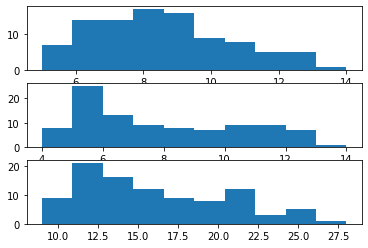

In [36]:
lA, lB, lC = gpn.get_all_dists()
plt.subplot(3, 1, 1)
plt.hist(lA)
plt.subplot(3, 1, 2)
plt.hist(lB)
plt.subplot(3, 1, 3)
plt.hist(lC)

In [37]:
raise

RuntimeError: No active exception to reraise

In [ ]:
for x in [(-1, 117, 1), (117, 118, 0), (118, 47, 0), (-1, 120, 0), (120, 47, 0)]:
    print(gpn.dual(x))

In [ ]:
gpn.G.nodes[9], gpn.G.nodes[8], gpn.G.nodes[0]

In [ ]:
gpn.show_all()

In [ ]:
pos = nx.spring_layout(gpn.G, pos=pos, k=0.1, iterations=10)
gpn.update_all_dist()
gpn.show_dist(pos=pos, figsize=(8, 8))

In [ ]:
gpn.dual((125, 15)), gpn.ngb(15), gpn.ngb(7), gpn.dual((125, 7))

In [ ]:
raise

In [ ]:
list_inner = [gpn.G.degree(n) for n in gpn.G.nodes if not gpn.is_border_node(n)]
list_outer = [gpn.G.degree(n) for n in gpn.G.nodes if gpn.is_border_node(n)]

In [ ]:
plt.hist(list_inner)

In [ ]:
plt.hist(list_outer)

In [ ]:
gpn.show_all()

In [ ]:
raise

In [ ]:
# test 1
def test_func():
    gpn = GrowingPlanarNetwork()
    gpn.init_square(8)
    for i in range(500):
        if p_dupl():
            gpn.duplicate_random_node()
        else:
            gpn.remove_random_node()
    dist = np.array(list(nx.betweenness_centrality(gpn.G).values()))
    return (skew(dist), kurtosis(dist), gpn.G, gpn.D)

for i in range(10):
    S, K, G, D = test_func()
    print(G.size(), D.degree(-1))

In [ ]:
G = gpn.G

In [ ]:
pos = nx.spring_layout(G, k=0.1, iterations=50)
pos = nx.planar_layout(gpn.G)
plt.figure(figsize=(12, 12))
nx.draw_networkx(gpn.G, pos=pos)

In [ ]:
pos = nx.planar_layout(Gstart)
plt.figure(figsize=(12, 12))
nx.draw_networkx(Gstart, pos=pos)

In [ ]:
raise

In [ ]:
gpn.show_all()

In [ ]:
ls_ngb = [len(gpn.ngb(x)) for x in gpn.G.nodes]

In [ ]:
plt.hist(ls_ngb)

In [ ]:
raise

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb

In [ ]:
gpn.stabilize_ngb(10)

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb